# Método de Búsqueda Aleatoria (Random Search)
## Optimización estocástica para encontrar máximos y mínimos locales

La búsqueda aleatoria es un método de optimización global que explora el espacio de búsqueda mediante muestreo aleatorio uniforme. Es especialmente útil cuando:
- La función objetivo es multimodal (tiene varios extremos locales)
- No se dispone de información sobre gradientes
- Se busca una solución rápida y robusta

**Ventajas:**
- Simple de implementar
- No requiere derivadas
- Buena exploración global
- Robusto ante ruido

**Desventajas:**
- Convergencia lenta
- No garantiza encontrar el óptimo global
- Requiere muchas evaluaciones de función

In [59]:
# Celda 1: Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
from typing import Callable, Tuple, Optional

# Configuración para mejores gráficas
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass  # Usar estilo por defecto si no está disponible

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✅ Librerías importadas correctamente")
print(f"📊 Numpy versión: {np.__version__}")
print(f"📈 Matplotlib backend: {plt.get_backend()}")

✅ Librerías importadas correctamente
📊 Numpy versión: 1.26.4
📈 Matplotlib backend: module://matplotlib_inline.backend_inline


In [60]:
# Celda 2: Funciones auxiliares de validación
def validar_entradas(func: Callable, a: float, b: float, n_iter: int, find_max: bool) -> None:
    """
    Valida los parámetros de entrada para el método de búsqueda aleatoria.
    
    Args:
        func: Función objetivo a optimizar
        a: Límite inferior del intervalo
        b: Límite superior del intervalo  
        n_iter: Número de iteraciones
        find_max: Si buscar máximo (True) o mínimo (False)
    
    Raises:
        ValueError: Si algún parámetro es inválido
        TypeError: Si func no es callable
    """
    if not callable(func):
        raise TypeError("El parámetro 'func' debe ser una función callable")
    
    if not isinstance(a, (int, float)) or not isinstance(b, (int, float)):
        raise TypeError("Los límites 'a' y 'b' deben ser números")
    
    if a >= b:
        raise ValueError(f"El límite inferior 'a' ({a}) debe ser menor que 'b' ({b})")
    
    if not isinstance(n_iter, int) or n_iter <= 0:
        raise ValueError(f"El número de iteraciones debe ser un entero positivo, recibido: {n_iter}")
    
    if not isinstance(find_max, bool):
        raise TypeError("El parámetro 'find_max' debe ser booleano (True/False)")
    
    # Validar que la función sea evaluable en el intervalo
    try:
        test_points = [a, (a + b) / 2, b]
        for point in test_points:
            result = func(point)
            if not isinstance(result, (int, float)) or np.isnan(result) or np.isinf(result):
                raise ValueError(f"La función devuelve un valor inválido en x={point}: {result}")
    except Exception as e:
        raise ValueError(f"Error al evaluar la función en el intervalo [{a}, {b}]: {str(e)}")

def detectar_funcion_constante(func: Callable, a: float, b: float, n_muestras: int = 20) -> bool:
    """
    Detecta si una función es aproximadamente constante en un intervalo.
    
    Args:
        func: Función a evaluar
        a, b: Límites del intervalo
        n_muestras: Número de puntos a muestrear
    
    Returns:
        True si la función parece constante, False en caso contrario
    """
    x_test = np.linspace(a, b, n_muestras)
    y_test = [func(x) for x in x_test]
    varianza = np.var(y_test)
    return varianza < 1e-10

print("✅ Funciones de validación definidas")

✅ Funciones de validación definidas


In [61]:
# Celda 3: Implementación principal del método de búsqueda aleatoria
def random_search(func: Callable, 
                 a: Optional[float] = None, 
                 b: Optional[float] = None, 
                 n_iter: int = 1000, 
                 find_max: bool = True,
                 semilla: Optional[int] = None,
                 mostrar_progreso: bool = True) -> Tuple[float, float, pd.DataFrame, dict]:
    """
    Implementa el método de búsqueda aleatoria para optimización de funciones unidimensionales.
    
    Args:
        func: Función objetivo a optimizar
        a: Límite inferior del intervalo (None para usar valores por defecto)
        b: Límite superior del intervalo (None para usar valores por defecto)
        n_iter: Número de iteraciones aleatorias (default: 1000)
        find_max: Si buscar máximo (True) o mínimo (False) (default: True)
        semilla: Semilla para reproducibilidad (opcional)
        mostrar_progreso: Si mostrar información durante la ejecución
    
    Returns:
        Tupla con (x_optimo, f_optimo, tabla_iteraciones, estadisticas)
    """
    
    # Configurar semilla para reproducibilidad
    if semilla is not None:
        np.random.seed(semilla)
    
    # Usar valores por defecto si no se especifican límites
    if a is None or b is None:
        if mostrar_progreso:
            print("🔍 Usando intervalo por defecto [-5, 5]")
        a, b = -5.0, 5.0
    
    # Validar entradas
    validar_entradas(func, a, b, n_iter, find_max)
    
    # Detectar función constante y advertir
    if detectar_funcion_constante(func, a, b):
        tipo_busqueda = "máximo" if find_max else "mínimo"
        warnings.warn(f"⚠️  La función parece ser constante en [{a}, {b}]. "
                     f"Buscar {tipo_busqueda} puede no ser significativo.", UserWarning)
    
    # Inicializar variables
    tiempo_inicio = time.time()
    
    # Listas para almacenar resultados
    iteraciones = []
    x_aleatorios = []
    valores_funcion = []
    mejores_hasta_ahora = []
    
    # Inicializar con el primer punto aleatorio
    x_optimo = np.random.uniform(a, b)
    f_optimo = func(x_optimo)
    actualizaciones_optimo = 1
    
    # Bucle principal de búsqueda aleatoria
    for i in range(n_iter):
        # Generar punto aleatorio uniforme en [a, b]
        x_random = np.random.uniform(a, b)
        f_random = func(x_random)
        
        # Actualizar óptimo según el tipo de búsqueda
        if find_max:
            if f_random > f_optimo:
                x_optimo, f_optimo = x_random, f_random
                actualizaciones_optimo += 1
        else:
            if f_random < f_optimo:
                x_optimo, f_optimo = x_random, f_random
                actualizaciones_optimo += 1
        
        # Registrar iteración
        iteraciones.append(i + 1)
        x_aleatorios.append(x_random)
        valores_funcion.append(f_random)
        mejores_hasta_ahora.append(f_optimo)
        
        # Mostrar progreso cada 20% del total
        if mostrar_progreso and (i + 1) % (n_iter // 5) == 0:
            porcentaje = (i + 1) / n_iter * 100
            tipo = "máx" if find_max else "mín"
            print(f"📊 Progreso: {porcentaje:.0f}% | {tipo} actual: f({x_optimo:.4f}) = {f_optimo:.6f}")
    
    tiempo_total = time.time() - tiempo_inicio
    
    # Crear tabla de iteraciones
    tabla = pd.DataFrame({
        'Iteración': iteraciones,
        'x_aleatorio': np.round(x_aleatorios, 6),
        'f(x)': np.round(valores_funcion, 6),
        'Mejor_hasta_ahora': np.round(mejores_hasta_ahora, 6)
    })
    
    # Estadísticas de ejecución
    inicio_convergencia = max(0, len(mejores_hasta_ahora) - min(100, n_iter))
    convergencia_final = abs(mejores_hasta_ahora[-1] - mejores_hasta_ahora[inicio_convergencia]) if len(mejores_hasta_ahora) > 1 else 0
    
    estadisticas = {
        'tiempo_ejecucion': tiempo_total,
        'actualizaciones_optimo': actualizaciones_optimo,
        'tasa_mejora': actualizaciones_optimo / n_iter,
        'intervalo': (a, b),
        'tipo_busqueda': 'máximo' if find_max else 'mínimo',
        'convergencia_final': convergencia_final
    }
    
    if mostrar_progreso:
        tipo = "Máximo" if find_max else "Mínimo"
        print(f"\n🎯 {tipo} encontrado:")
        print(f"   x* = {x_optimo:.8f}")
        print(f"   f(x*) = {f_optimo:.8f}")
        print(f"\n⏱️  Tiempo de ejecución: {tiempo_total:.4f} segundos")
        print(f"🔄 Actualizaciones del óptimo: {actualizaciones_optimo}/{n_iter} ({estadisticas['tasa_mejora']:.2%})")
    
    return x_optimo, f_optimo, tabla, estadisticas

print("✅ Función de búsqueda aleatoria implementada")

✅ Función de búsqueda aleatoria implementada


In [62]:
# Celda 4: Función de visualización
def graficar_resultados(func: Callable, x_optimo: float, f_optimo: float, 
                       tabla: pd.DataFrame, estadisticas: dict, 
                       mostrar_todas_iteraciones: bool = False) -> None:
    """
    Crea visualizaciones del proceso de búsqueda aleatoria.
    
    Args:
        func: Función objetivo
        x_optimo: Punto óptimo encontrado
        f_optimo: Valor óptimo de la función
        tabla: DataFrame con iteraciones
        estadisticas: Diccionario con estadísticas de ejecución
        mostrar_todas_iteraciones: Si mostrar todos los puntos muestreados
    """
    a, b = estadisticas['intervalo']
    tipo_busqueda = estadisticas['tipo_busqueda']
    
    # Crear figura con subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Subplot 1: Función y punto óptimo
    x_continuo = np.linspace(a, b, 1000)
    y_continuo = [func(x) for x in x_continuo]
    
    ax1.plot(x_continuo, y_continuo, 'b-', linewidth=2.5, label='f(x)', alpha=0.8)
    
    # Marcar el óptimo encontrado
    color_optimo = 'red' if tipo_busqueda == 'máximo' else 'green'
    marker_optimo = '^' if tipo_busqueda == 'máximo' else 'v'
    ax1.scatter(x_optimo, f_optimo, c=color_optimo, s=200, marker=marker_optimo, 
               edgecolors='black', linewidth=2, 
               label=f'{tipo_busqueda.capitalize()}: f({x_optimo:.4f}) = {f_optimo:.6f}',
               zorder=5)
    
    # Mostrar algunos puntos muestreados si se solicita
    if mostrar_todas_iteraciones and len(tabla) > 0:
        # Mostrar solo una muestra para no saturar la gráfica
        n_mostrar = min(100, len(tabla))
        indices_muestra = np.random.choice(len(tabla), n_mostrar, replace=False)
        x_muestra = tabla.iloc[indices_muestra]['x_aleatorio']
        y_muestra = tabla.iloc[indices_muestra]['f(x)']
        ax1.scatter(x_muestra, y_muestra, c='orange', s=10, alpha=0.4, 
                   label=f'Muestra de {n_mostrar} puntos evaluados')
    
    ax1.set_xlabel('x', fontsize=12, fontweight='bold')
    ax1.set_ylabel('f(x)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Búsqueda Aleatoria - {tipo_busqueda.capitalize()} Global\n'
                 f'Intervalo: [{a}, {b}] | Iteraciones: {len(tabla):,}', 
                 fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Convergencia del óptimo
    ax2.plot(tabla['Iteración'], tabla['Mejor_hasta_ahora'], 'g-', linewidth=2, 
            label=f'Convergencia del {tipo_busqueda}')
    ax2.axhline(y=f_optimo, color='red', linestyle='--', alpha=0.7, 
               label=f'Valor final: {f_optimo:.6f}')
    
    ax2.set_xlabel('Iteración', fontsize=12, fontweight='bold')
    ax2.set_ylabel(f'Mejor {tipo_busqueda} encontrado', fontsize=12, fontweight='bold')
    ax2.set_title('Convergencia del Algoritmo de Búsqueda Aleatoria', 
                 fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Añadir estadísticas como texto
    stats_text = (f"Actualizaciones: {estadisticas['actualizaciones_optimo']} "
                 f"({estadisticas['tasa_mejora']:.1%})\n"
                 f"Tiempo: {estadisticas['tiempo_ejecucion']:.3f}s")
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("✅ Función de visualización definida")

✅ Función de visualización definida


In [63]:
# Celda 5: Ejemplo 1 - Función cuadrática (búsqueda de mínimo)
print("🔢 EJEMPLO 1: Función Cuadrática - Búsqueda de Mínimo")
print("="*60)

# Definir función cuadrática
def funcion_cuadratica(x):
    """Función cuadrática: f(x) = x² - 4x + 5"""
    return x**2 - 4*x + 5

# El mínimo teórico está en x = 2, f(2) = 1
print("📝 Función: f(x) = x² - 4x + 5")
print("🎯 Mínimo teórico: x = 2, f(2) = 1")
print("📍 Intervalo de búsqueda: [0, 5]")
print()

# Ejecutar búsqueda aleatoria
x_min, f_min, tabla_cuadratica, stats_cuadratica = random_search(
    func=funcion_cuadratica,
    a=0,
    b=5,
    n_iter=1500,
    find_max=False,  # Buscar mínimo
    semilla=42,
    mostrar_progreso=True
)

print("\n📊 Primeras 10 iteraciones:")
print(tabla_cuadratica.head(10))

print("\n📊 Últimas 10 iteraciones:")
print(tabla_cuadratica.tail(10))

# Calcular error respecto al óptimo teórico
error_x = abs(x_min - 2)
error_f = abs(f_min - 1)
print(f"\n🎯 Precisión del resultado:")
print(f"   Error en x: {error_x:.6f} (teórico: x = 2)")
print(f"   Error en f(x): {error_f:.6f} (teórico: f(x) = 1)")

🔢 EJEMPLO 1: Función Cuadrática - Búsqueda de Mínimo
📝 Función: f(x) = x² - 4x + 5
🎯 Mínimo teórico: x = 2, f(2) = 1
📍 Intervalo de búsqueda: [0, 5]

📊 Progreso: 20% | mín actual: f(1.9655) = 1.001191
📊 Progreso: 40% | mín actual: f(1.9925) = 1.000056
📊 Progreso: 60% | mín actual: f(2.0038) = 1.000015
📊 Progreso: 80% | mín actual: f(2.0038) = 1.000015
📊 Progreso: 100% | mín actual: f(2.0038) = 1.000015

🎯 Mínimo encontrado:
   x* = 2.00381530
   f(x*) = 1.00001456

⏱️  Tiempo de ejecución: 0.0090 segundos
🔄 Actualizaciones del óptimo: 7/1500 (0.47%)

📊 Primeras 10 iteraciones:
   Iteración  x_aleatorio      f(x)  Mejor_hasta_ahora
0          1     4.753572  8.582156           1.016205
1          2     3.659970  3.755499           1.016205
2          3     2.993292  1.986630           1.016205
3          4     0.780093  2.488173           1.016205
4          5     0.779973  2.488467           1.016205
5          6     0.290418  3.922670           1.016205
6          7     4.330881  6.43

📈 Visualización del Ejemplo 1: Función Cuadrática


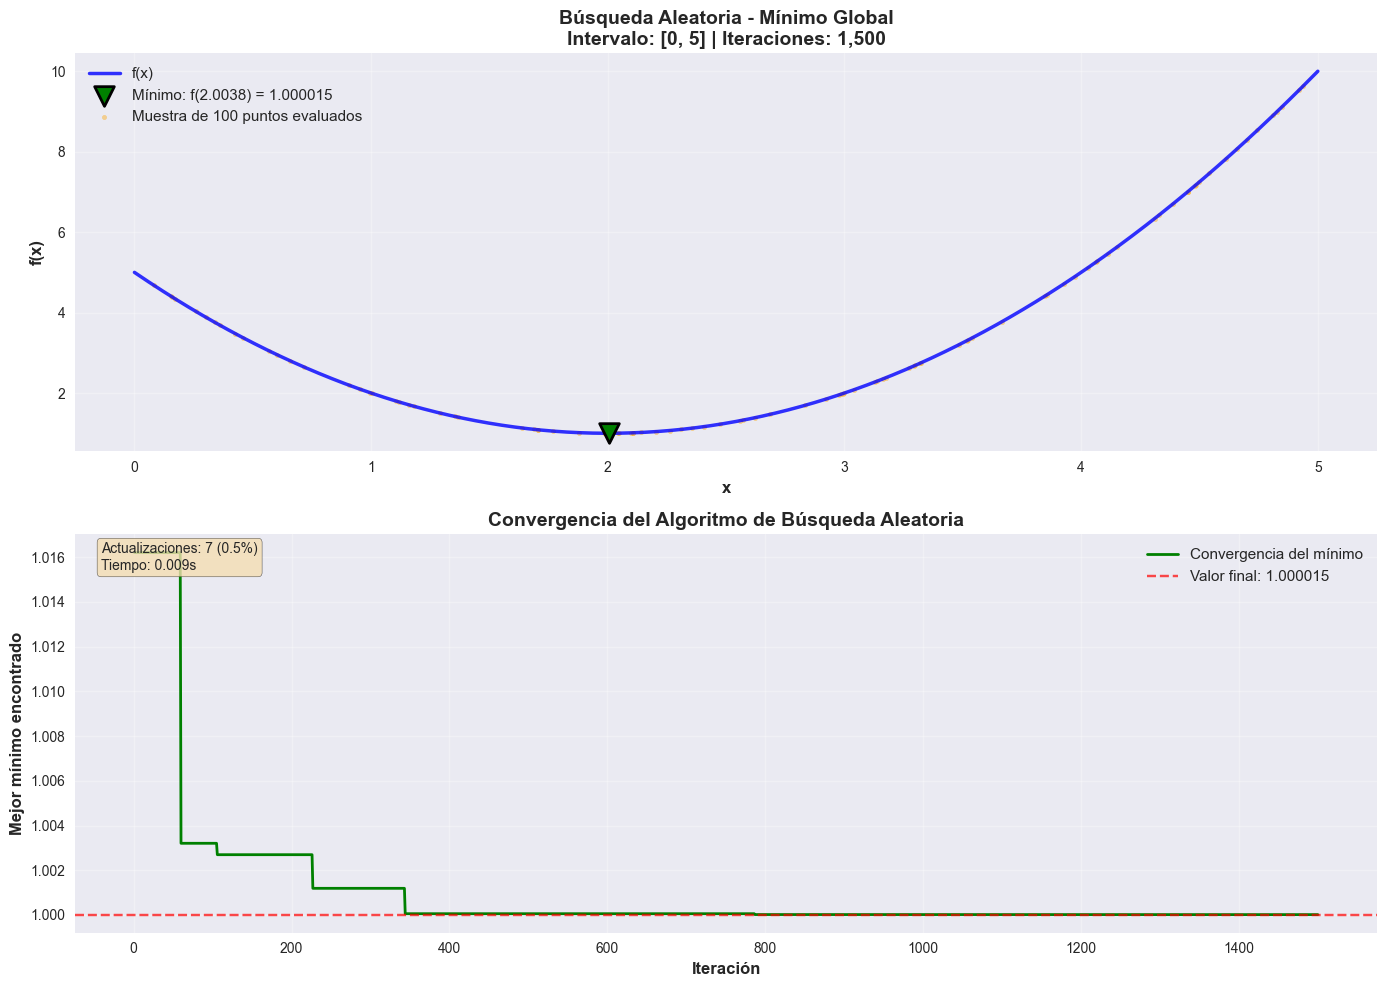

In [64]:
# Celda 6: Visualización del Ejemplo 1
print("📈 Visualización del Ejemplo 1: Función Cuadrática")
graficar_resultados(funcion_cuadratica, x_min, f_min, tabla_cuadratica, stats_cuadratica, 
                   mostrar_todas_iteraciones=True)

In [65]:
# Celda 7: Ejemplo 2 - Función trigonométrica compleja (búsqueda de máximo)
print("🌊 EJEMPLO 2: Función Trigonométrica - Búsqueda de Máximo")
print("="*60)

# Definir función trigonométrica con decaimiento exponencial
def funcion_trigonometrica(x):
    """Función trigonométrica: f(x) = sin(x) * exp(-x/5)"""
    return np.sin(x) * np.exp(-x/5)

print("📝 Función: f(x) = sin(x) * exp(-x/5)")
print("🎯 Función con múltiples máximos locales y decaimiento exponencial")
print("📍 Intervalo de búsqueda: [0, 15]")
print()

# Ejecutar búsqueda aleatoria
x_max, f_max, tabla_trigonometrica, stats_trigonometrica = random_search(
    func=funcion_trigonometrica,
    a=0,
    b=15,
    n_iter=2000,
    find_max=True,  # Buscar máximo
    semilla=123,
    mostrar_progreso=True
)

print("\n📊 Primeras 10 iteraciones:")
print(tabla_trigonometrica.head(10))

print("\n📊 Últimas 10 iteraciones:")
print(tabla_trigonometrica.tail(10))

# El máximo teórico aproximado está cerca de x ≈ π/2 ≈ 1.571
x_teorico = np.pi/2
f_teorico = funcion_trigonometrica(x_teorico)
print(f"\n🎯 Comparación con máximo teórico aproximado:")
print(f"   Máximo teórico: x ≈ {x_teorico:.6f}, f(x) ≈ {f_teorico:.6f}")
print(f"   Máximo encontrado: x = {x_max:.6f}, f(x) = {f_max:.6f}")
print(f"   Diferencia: {abs(f_max - f_teorico):.6f}")

🌊 EJEMPLO 2: Función Trigonométrica - Búsqueda de Máximo
📝 Función: f(x) = sin(x) * exp(-x/5)
🎯 Función con múltiples máximos locales y decaimiento exponencial
📍 Intervalo de búsqueda: [0, 15]

📊 Progreso: 20% | máx actual: f(1.3694) = 0.745054
📊 Progreso: 40% | máx actual: f(1.3694) = 0.745054
📊 Progreso: 60% | máx actual: f(1.3694) = 0.745054
📊 Progreso: 80% | máx actual: f(1.3694) = 0.745054
📊 Progreso: 100% | máx actual: f(1.3694) = 0.745054

🎯 Máximo encontrado:
   x* = 1.36944513
   f(x*) = 0.74505395

⏱️  Tiempo de ejecución: 0.0161 segundos
🔄 Actualizaciones del óptimo: 6/2000 (0.30%)

📊 Primeras 10 iteraciones:
   Iteración  x_aleatorio      f(x)  Mejor_hasta_ahora
0          1     4.292090 -0.386945          -0.105603
1          2     3.402772 -0.130746          -0.105603
2          3     8.269722  0.174999           0.174999
3          4    10.792035 -0.113125           0.174999
4          5     6.346597  0.017808           0.174999
5          6    14.711463  0.044283       

📈 Visualización del Ejemplo 2: Función Trigonométrica


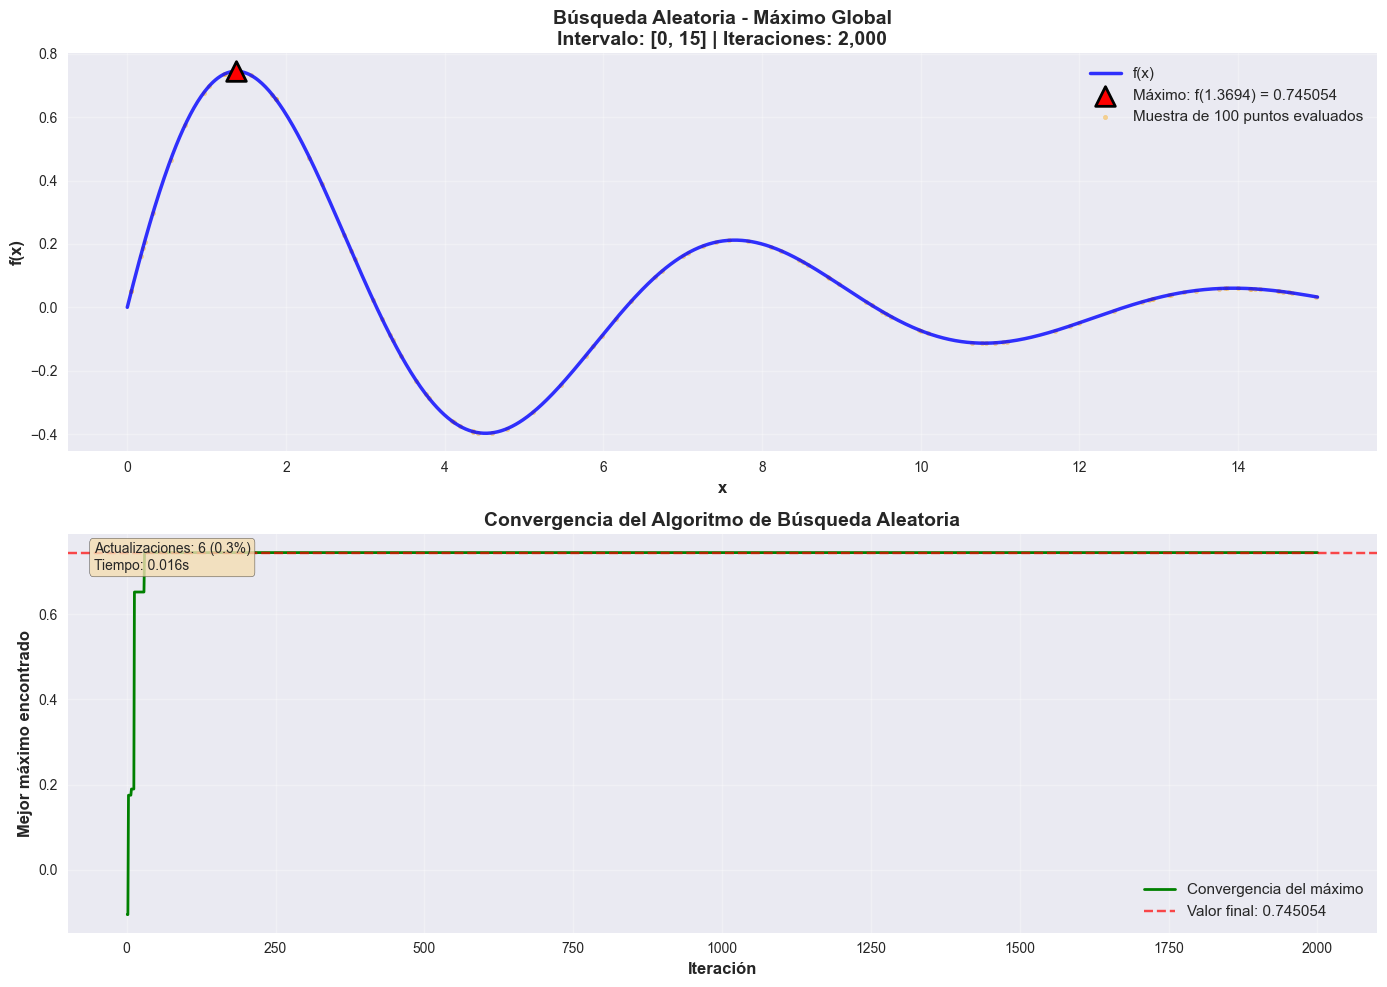

In [66]:
# Celda 8: Visualización del Ejemplo 2
print("📈 Visualización del Ejemplo 2: Función Trigonométrica")
graficar_resultados(funcion_trigonometrica, x_max, f_max, tabla_trigonometrica, 
                   stats_trigonometrica, mostrar_todas_iteraciones=True)

In [67]:
# Celda 9: Análisis comparativo y demostración de personalización
print("🔍 ANÁLISIS COMPARATIVO: Efectos del número de iteraciones")
print("="*65)

# Definir función de prueba más compleja
def funcion_compleja(x):
    """Función compleja multimodal: f(x) = -x²*sin(5x) + x*cos(3x)"""
    return -x**2 * np.sin(5*x) + x * np.cos(3*x)

print("📝 Función de prueba: f(x) = -x²*sin(5x) + x*cos(3x)")
print("🎯 Función multimodal con múltiples extremos locales")
print()

# Probar con diferentes números de iteraciones
iteraciones_prueba = [100, 500, 1000, 2000]
resultados_comparativos = []

for n_iter in iteraciones_prueba:
    print(f"🔄 Probando con {n_iter} iteraciones...")
    
    x_opt, f_opt, _, stats = random_search(
        func=funcion_compleja,
        a=-3,
        b=3,
        n_iter=n_iter,
        find_max=True,
        semilla=456,  # Misma semilla para comparación justa
        mostrar_progreso=False
    )
    
    resultados_comparativos.append({
        'Iteraciones': n_iter,
        'x_óptimo': round(x_opt, 6),
        'f_óptimo': round(f_opt, 6),
        'Tiempo(s)': round(stats['tiempo_ejecucion'], 4),
        'Actualizaciones': stats['actualizaciones_optimo'],
        'Tasa_mejora': f"{stats['tasa_mejora']:.2%}"
    })

# Mostrar tabla comparativa
df_comparativo = pd.DataFrame(resultados_comparativos)
print("\n📊 Tabla comparativa de resultados:")
print(df_comparativo.to_string(index=False))

print("\n🎯 Observaciones:")
print("   • Más iteraciones generalmente mejoran la calidad de la solución")
print("   • La tasa de mejora disminuye con más iteraciones (ley de rendimientos decrecientes)")
print("   • El tiempo de ejecución es prácticamente lineal con el número de iteraciones")

🔍 ANÁLISIS COMPARATIVO: Efectos del número de iteraciones
📝 Función de prueba: f(x) = -x²*sin(5x) + x*cos(3x)
🎯 Función multimodal con múltiples extremos locales

🔄 Probando con 100 iteraciones...
🔄 Probando con 500 iteraciones...
🔄 Probando con 1000 iteraciones...
🔄 Probando con 2000 iteraciones...

📊 Tabla comparativa de resultados:
 Iteraciones  x_óptimo  f_óptimo  Tiempo(s)  Actualizaciones Tasa_mejora
         100 -2.856631  9.948359     0.0010                5       5.00%
         500 -2.884294 10.052054     0.0050                7       1.40%
        1000 -2.886369 10.052853     0.0130                8       0.80%
        2000 -2.886369 10.052853     0.0188                8       0.40%

🎯 Observaciones:
   • Más iteraciones generalmente mejoran la calidad de la solución
   • La tasa de mejora disminuye con más iteraciones (ley de rendimientos decrecientes)
   • El tiempo de ejecución es prácticamente lineal con el número de iteraciones


🎮 EJEMPLO INTERACTIVO: Personaliza tu búsqueda
Puedes modificar estos parámetros directamente en el código:

📝 Función personalizada: f(x) = x**3 - 6*x**2 + 9*x + 1
📍 Intervalo: [-1, 5]
🔄 Iteraciones: 1200
🎯 Tipo de búsqueda: Mínimo

📊 Progreso: 20% | mín actual: f(-0.9852) = -14.647794
📊 Progreso: 40% | mín actual: f(-0.9941) = -14.859726
📊 Progreso: 60% | mín actual: f(-0.9941) = -14.859726
📊 Progreso: 80% | mín actual: f(-0.9941) = -14.859726
📊 Progreso: 100% | mín actual: f(-0.9941) = -14.859726

🎯 Mínimo encontrado:
   x* = -0.99414239
   f(x*) = -14.85972585

⏱️  Tiempo de ejecución: 0.0368 segundos
🔄 Actualizaciones del óptimo: 7/1200 (0.58%)

📊 Últimas 15 iteraciones de tu búsqueda personalizada:
      Iteración  x_aleatorio       f(x)  Mejor_hasta_ahora
1185       1186     3.394146   1.527285         -14.859726
1186       1187     2.382605   1.908193         -14.859726
1187       1188     3.093470   1.027026         -14.859726
1188       1189     0.633870   4.548768         -1

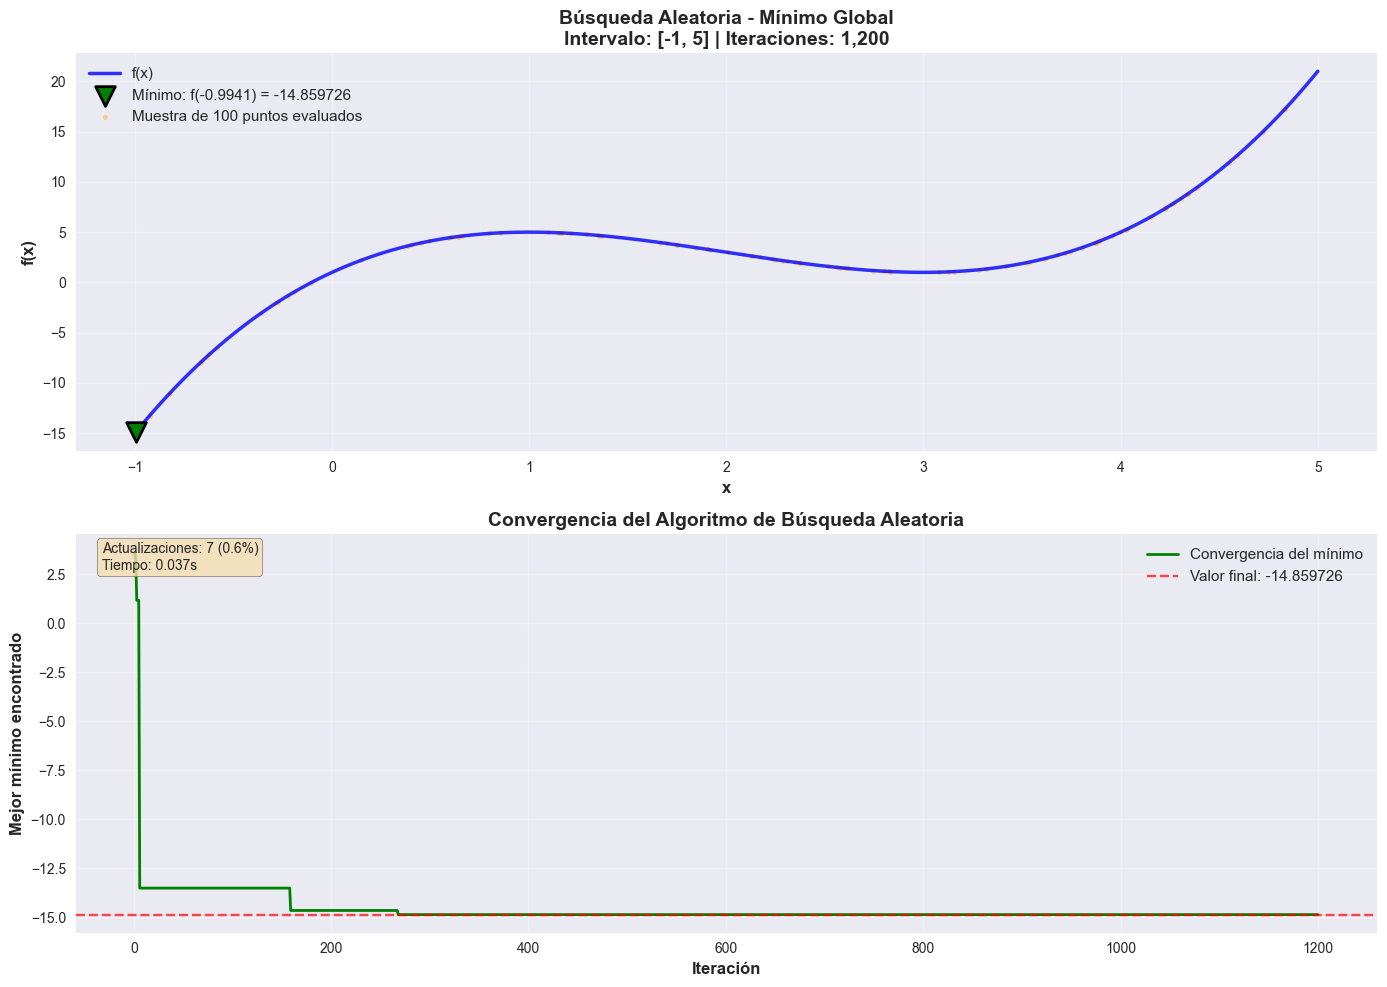

In [68]:
# Celda 10: Ejemplo interactivo personalizable
print("🎮 EJEMPLO INTERACTIVO: Personaliza tu búsqueda")
print("="*50)

# Función personalizable por el usuario
print("Puedes modificar estos parámetros directamente en el código:")
print()

# Parámetros personalizables
# Cambia estos valores para experimentar
mi_funcion_str = "x**3 - 6*x**2 + 9*x + 1"  # Cambia esta expresión
mi_intervalo_a = -1  # Cambia el límite inferior
mi_intervalo_b = 5   # Cambia el límite superior
mis_iteraciones = 1200  # Cambia el número de iteraciones
buscar_maximo = False   # Cambia a True para buscar máximo

print(f"📝 Función personalizada: f(x) = {mi_funcion_str}")
print(f"📍 Intervalo: [{mi_intervalo_a}, {mi_intervalo_b}]")
print(f"🔄 Iteraciones: {mis_iteraciones}")
print(f"🎯 Tipo de búsqueda: {'Máximo' if buscar_maximo else 'Mínimo'}")
print()

# Crear función a partir del string
def mi_funcion_personalizada(x):
    """Función definida por el usuario"""
    return eval(mi_funcion_str)

try:
    # Ejecutar búsqueda personalizada
    x_personal, f_personal, tabla_personal, stats_personal = random_search(
        func=mi_funcion_personalizada,
        a=mi_intervalo_a,
        b=mi_intervalo_b,
        n_iter=mis_iteraciones,
        find_max=buscar_maximo,
        semilla=789,
        mostrar_progreso=True
    )
    
    print("\n📊 Últimas 15 iteraciones de tu búsqueda personalizada:")
    print(tabla_personal.tail(15))
    
    # Visualizar resultado personalizado
    print("\n📈 Visualización de tu función personalizada:")
    graficar_resultados(mi_funcion_personalizada, x_personal, f_personal, 
                       tabla_personal, stats_personal, mostrar_todas_iteraciones=True)
    
except Exception as e:
    print(f"❌ Error en la función personalizada: {e}")
    print("💡 Verifica que la expresión matemática sea válida en Python")
    print("   Ejemplos válidos: 'x**2 + 3*x - 1', 'np.sin(x) + np.cos(2*x)', 'x**3 - 2*x'")

📊 ANÁLISIS DE CONVERGENCIA DEL ERROR
🎯 Analizando convergencia para f(x) = x² - 4x + 5
   Óptimo teórico: x = 2, f(2) = 1


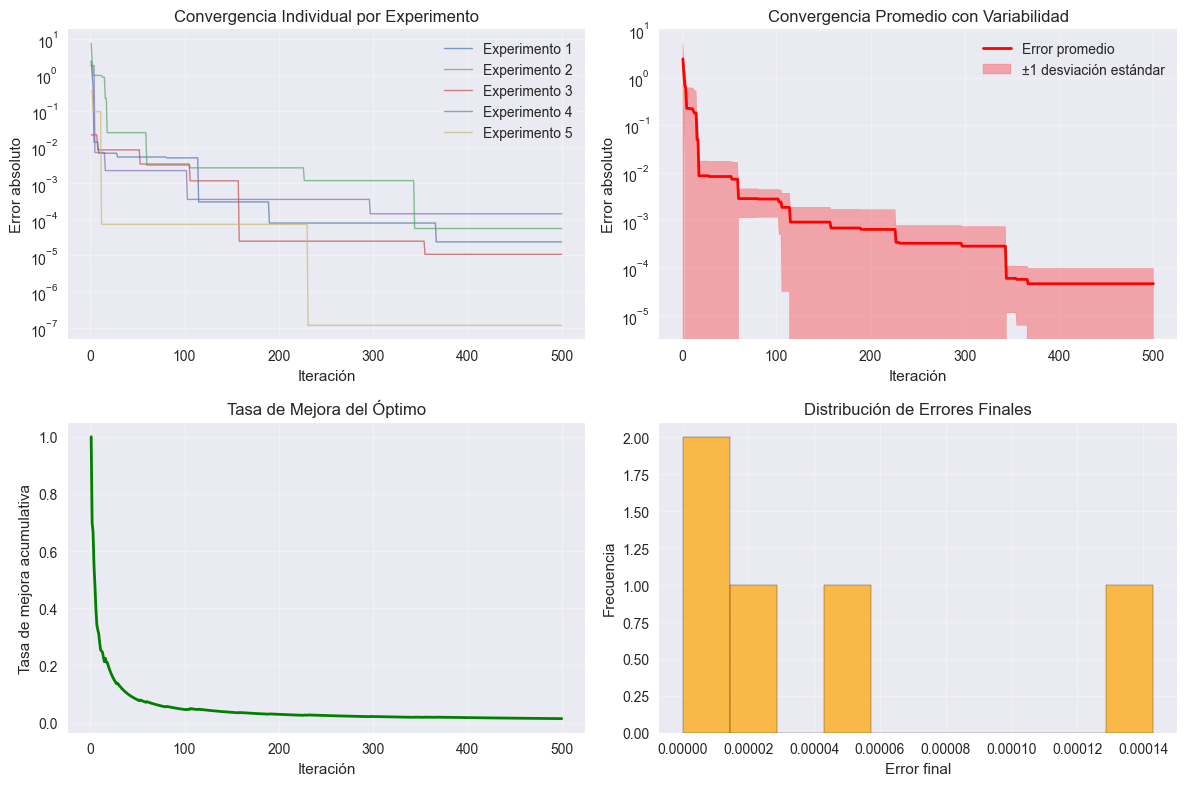


📈 Estadísticas de convergencia (5 experimentos):
   Error final promedio: 0.000047
   Desviación estándar: 0.000052
   Error mínimo encontrado: 0.000000
   Error máximo encontrado: 0.000143
   Tasa de mejora final promedio: 0.0140


In [69]:
# Celda 11: Análisis de convergencia del error para búsqueda aleatoria
print("📊 ANÁLISIS DE CONVERGENCIA DEL ERROR")
print("="*45)

# Función para calcular error respecto al óptimo teórico
def analizar_convergencia_busqueda_aleatoria(func, x_teorico, intervalo, n_iter=1000, n_experimentos=5):
    """
    Analiza la convergencia del error en múltiples experimentos de búsqueda aleatoria.
    """
    a, b = intervalo
    errores_experimentos = []
    
    for exp in range(n_experimentos):
        _, _, tabla, _ = random_search(func, a, b, n_iter, find_max=False, 
                                     semilla=exp*42, mostrar_progreso=False)
        
        # Calcular error respecto al óptimo teórico
        errores = [abs(tabla['x_aleatorio'].iloc[:i+1].apply(func).min() - func(x_teorico)) 
                  for i in range(len(tabla))]
        errores_experimentos.append(errores)
    
    return errores_experimentos

# Análisis para función cuadrática
print("🎯 Analizando convergencia para f(x) = x² - 4x + 5")
print("   Óptimo teórico: x = 2, f(2) = 1")

errores_exp = analizar_convergencia_busqueda_aleatoria(
    func=lambda x: x**2 - 4*x + 5,
    x_teorico=2,
    intervalo=(0, 5),
    n_iter=500,
    n_experimentos=5
)

# Gráfica de convergencia del error
plt.figure(figsize=(12, 8))

# Subplot 1: Convergencia individual de cada experimento
plt.subplot(2, 2, 1)
for i, errores in enumerate(errores_exp):
    plt.semilogy(range(1, len(errores)+1), errores, alpha=0.7, 
                linewidth=1, label=f'Experimento {i+1}')
plt.xlabel('Iteración')
plt.ylabel('Error absoluto')
plt.title('Convergencia Individual por Experimento')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 2: Convergencia promedio
plt.subplot(2, 2, 2)
errores_promedio = np.mean(errores_exp, axis=0)
errores_std = np.std(errores_exp, axis=0)
iteraciones = range(1, len(errores_promedio)+1)

plt.semilogy(iteraciones, errores_promedio, 'r-', linewidth=2, label='Error promedio')
plt.fill_between(iteraciones, 
                errores_promedio - errores_std,
                errores_promedio + errores_std,
                alpha=0.3, color='red', label='±1 desviación estándar')
plt.xlabel('Iteración')
plt.ylabel('Error absoluto')
plt.title('Convergencia Promedio con Variabilidad')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 3: Tasa de mejora acumulativa
plt.subplot(2, 2, 3)
mejoras_acumulativas = []
for errores in errores_exp:
    mejoras = [1 if i == 0 or errores[i] < min(errores[:i]) else 0 for i in range(len(errores))]
    mejoras_acum = np.cumsum(mejoras) / np.arange(1, len(mejoras)+1)
    mejoras_acumulativas.append(mejoras_acum)

mejoras_promedio = np.mean(mejoras_acumulativas, axis=0)
plt.plot(iteraciones, mejoras_promedio, 'g-', linewidth=2)
plt.xlabel('Iteración')
plt.ylabel('Tasa de mejora acumulativa')
plt.title('Tasa de Mejora del Óptimo')
plt.grid(True, alpha=0.3)

# Subplot 4: Distribución de errores finales
plt.subplot(2, 2, 4)
errores_finales = [errores[-1] for errores in errores_exp]
plt.hist(errores_finales, bins=10, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Error final')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores Finales')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas finales
print(f"\n📈 Estadísticas de convergencia ({len(errores_exp)} experimentos):")
print(f"   Error final promedio: {np.mean(errores_finales):.6f}")
print(f"   Desviación estándar: {np.std(errores_finales):.6f}")
print(f"   Error mínimo encontrado: {min(errores_finales):.6f}")
print(f"   Error máximo encontrado: {max(errores_finales):.6f}")
print(f"   Tasa de mejora final promedio: {mejoras_promedio[-1]:.4f}")
